# HackLive - Guided Community Hackathon II

[Link to competition here!](https://datahack.analyticsvidhya.com/contest/hacklive-2-guided-community-hackathon/)

Go there and register to be able to download the dataset and submit your predictions. Click the button below to open this notebook in Google Colab!

<a href="https://colab.research.google.com/github/jpraguer/jpraguer.github.io/master/_posts/RegressionEDABaseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

As YouTube becomes one of the most popular video-sharing platforms, YouTuber is developed as a new type of career in recent decades. YouTubers earn money through advertising revenue from YouTube videos, sponsorships from companies, merchandise sales, and donations from their fans. In order to maintain a stable income, the popularity of videos become the top priority for YouTubers. Meanwhile, some of our friends are YouTubers or channel owners in other video-sharing platforms. This raises our interest in predicting the performance of the video. If creators can have a preliminary prediction and understanding on their videos’ performance, they may adjust their video to gain the most attention from the public.

You have been provided details on videos along with some features as well. Can you accurately predict the number of likes for each video using the set of input variables?

In [1]:
!pip install catboost

In [2]:
# import useful libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

from catboost import CatBoostRegressor

In [3]:
# load in data and set seed
BASE = 'https://drive.google.com/uc?export=download&id='
SEED = 2021

train = pd.read_csv(f'{BASE}1twZymRo0KT6IMIL7Q1wYoUSmHE3w3Buc')
test = pd.read_csv(f'{BASE}1Zu57FJCK4XpzX6_CzG_L4vlF9J73B9ke')
ss = pd.read_csv(f'{BASE}1s8iq0VaoTVkE9rQEAh1sfNuNdUgFjxYo')

In [4]:
# prepare a few key variables to classify columns into categorical and numeric
ID_COL, TARGET_COL = 'video_id', 'likes'

num_cols = ['views', 'dislikes', 'comment_count']
cat_cols = ['category_id', 'country_code']
text_cols = ['title', 'channel_title', 'tags', 'description']
date_cols = ['publish_date']

## EDA starts
First we look at the first few rows of the train dataset.

In [5]:
train.head(3)

,video_id,title,channel_title,category_id,publish_date,tags,views,dislikes,comment_count,description,country_code,likes
0,53364,Alif Allah Aur Insaan Episode 34 HUM TV Drama ...,HUM TV,24.0,2017-12-12,"HUM|""TV""|""Alif Allah Aur Insaan""|""Episode 34""|...",351430.0,298.0,900.0,Alif Allah Aur Insaan Episode 34 Full - 12 Dec...,CA,2351.0
1,51040,It's Showtime Miss Q & A: Bela gets jealous of...,ABS-CBN Entertainment,24.0,2018-03-08,"ABS-CBN Entertainment|""ABS-CBN""|""ABS-CBN Onlin...",461508.0,74.0,314.0,Vice Ganda notices Bela Padilla's sudden chang...,CA,3264.0
2,1856,ದರ್ಶನ್ ಗೆ ಬಾರಿ ಅವಮಾನ ಮಾಡಿದ ಶಿವಣ್ಣ ನಾಯಕಿ \n ಕ್...,SANDALWOOD REVIEWS,24.0,2018-03-26,"challenging star darshan latest news|""challeng...",40205.0,150.0,100.0,ದರ್ಶನ್ ಗೆ ಬಾರಿ ಅವಮಾನ ಮಾಡಿದ ಶಿವಣ್ಣ ನಾಯಕಿ ಕ್ಲ...,IN,580.0


In [6]:
ss.head(3)

,video_id,likes
0,87185,0
1,9431,0
2,40599,0


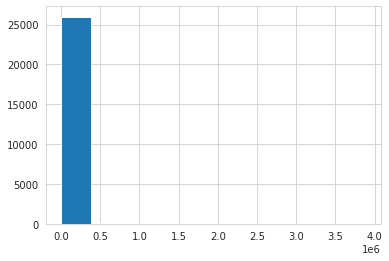

In [7]:
# look at distribution of target variable
train[TARGET_COL].hist();

Lots of zeroes! Definintely need to log transform to be able to analyse this variable. Luckily, GBDT regressors are resistant to log-normal distributions.

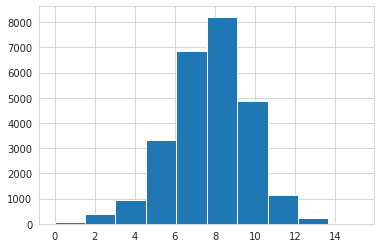

In [8]:
# look at distribution of target variable log-transformed
np.log1p(train[TARGET_COL]).hist();

In [9]:
# look at which variables are null and if they were parsed correctly
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26061 entries, 0 to 26060
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   video_id       26061 non-null  int64  
 1   title          26061 non-null  object 
 2   channel_title  26061 non-null  object 
 3   category_id    26061 non-null  float64
 4   publish_date   26061 non-null  object 
 5   tags           26061 non-null  object 
 6   views          26061 non-null  float64
 7   dislikes       26061 non-null  float64
 8   comment_count  26061 non-null  float64
 9   description    26061 non-null  object 
 10  country_code   26061 non-null  object 
 11  likes          26061 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 2.4+ MB


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11170 entries, 0 to 11169
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   video_id       11170 non-null  int64  
 1   title          11170 non-null  object 
 2   channel_title  11170 non-null  object 
 3   category_id    11170 non-null  float64
 4   publish_date   11170 non-null  object 
 5   tags           11170 non-null  object 
 6   views          11170 non-null  float64
 7   dislikes       11170 non-null  float64
 8   comment_count  11170 non-null  float64
 9   description    11170 non-null  object 
 10  country_code   11170 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 960.0+ KB


No nulls, which is great!

### Looking at categorical columns
Because of a few categorical columns I decided to set a baseline in Catboost. Here are value counts and target variable boxplots for all of them, they prove useful.

Analysing: category_id
Train top 5 counts:
24.0    9614
25.0    3725
22.0    2365
10.0    2099
23.0    1736
Name: category_id, dtype: int64
Test top 5 counts:
24.0    4105
25.0    1516
22.0     995
10.0     891
23.0     723
Name: category_id, dtype: int64


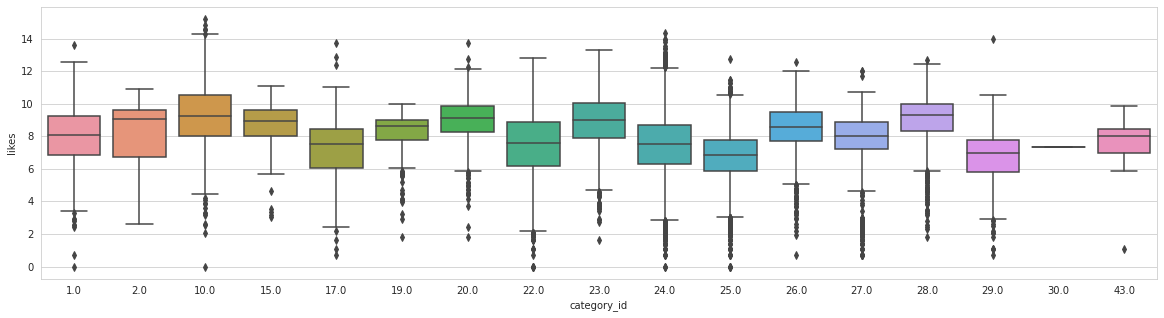



Analysing: country_code
Train top 5 counts:
IN    10401
CA    10326
US     3095
GB     2239
Name: country_code, dtype: int64
Test top 5 counts:
IN    4458
CA    4425
US    1327
GB     960
Name: country_code, dtype: int64


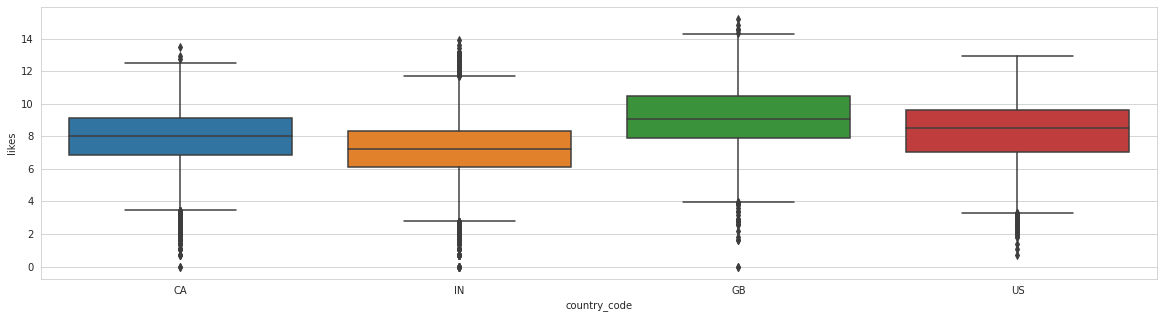

In [11]:
# print top 5 value counts and plot target boxplots
for col in cat_cols:
  print(f'Analysing: {col}\nTrain top 5 counts:')
  print(train[col].value_counts().head(5))
  print('Test top 5 counts:')
  print(test[col].value_counts().head(5))
  plt.figure(figsize=(20,5))
  sns.boxplot(x=train[col], y=np.log1p(train[TARGET_COL]))
  plt.show();
  print('\n')

In [12]:
# channel title could be used as a high cardinality categorical variable
train['channel_title'].value_counts()

SAB TV                165
SET India             128
ESPN                  122
Study IQ education    118
etvteluguindia        115
                     ... 
WGA West                1
PhantomStrider          1
Yarotska                1
KhalidVEVO              1
Christina Aguilera      1
Name: channel_title, Length: 5764, dtype: int64

In [13]:
# same with publish date
train['publish_date'].value_counts()

2018-01-29    199
2017-12-13    185
2018-01-19    181
2018-01-26    180
2018-01-12    179
             ... 
2017-09-26      1
2015-10-31      1
2017-09-09      1
2015-05-21      1
2017-10-20      1
Name: publish_date, Length: 348, dtype: int64

#### Observations
Strange dataset, will remove textual features for now. Another template shows how to deal with them in the [NLP template](https://jpraguer.github.io/NLP-EDA-Baseline/).

Canadian and Indian videos are the most common, where Canadian ones have more likes. There are fewer British and American ones, with British having the highest median likes.

Otherwise there is somewhat of a sine pattern in the likes distributions, we could maybe even use it as numerical. Let's stick to categorising it for now.

### Analysis of continuous variables
Let's plot distributions and correlations for numerical variables.

Analysing: views


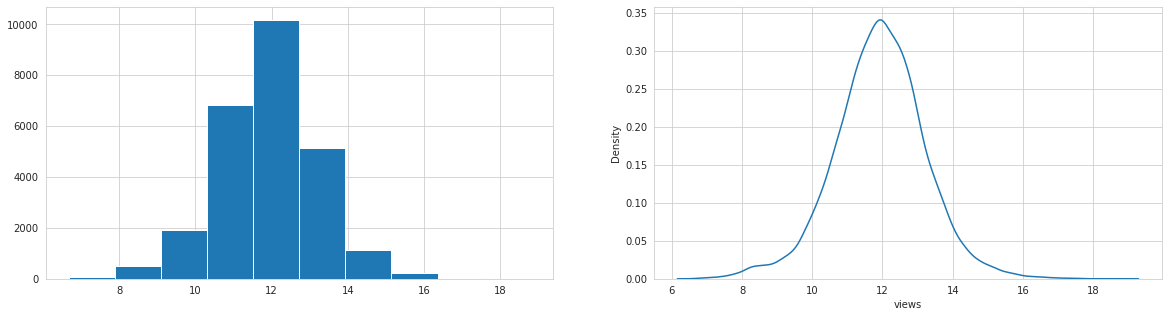



Analysing: dislikes


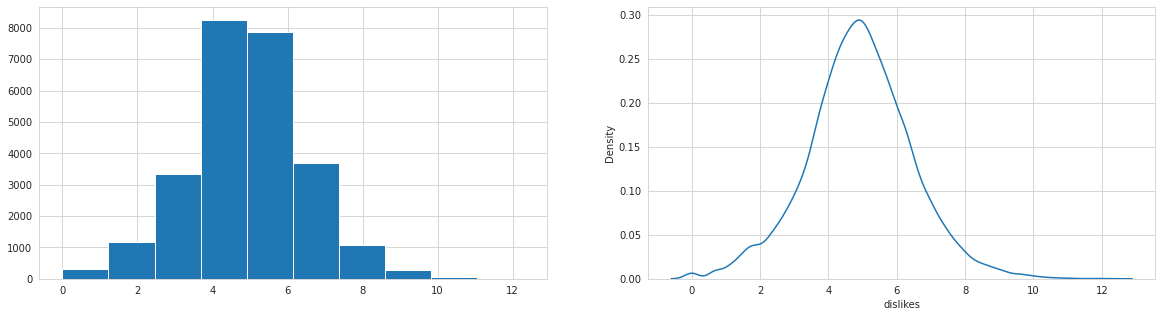



Analysing: comment_count


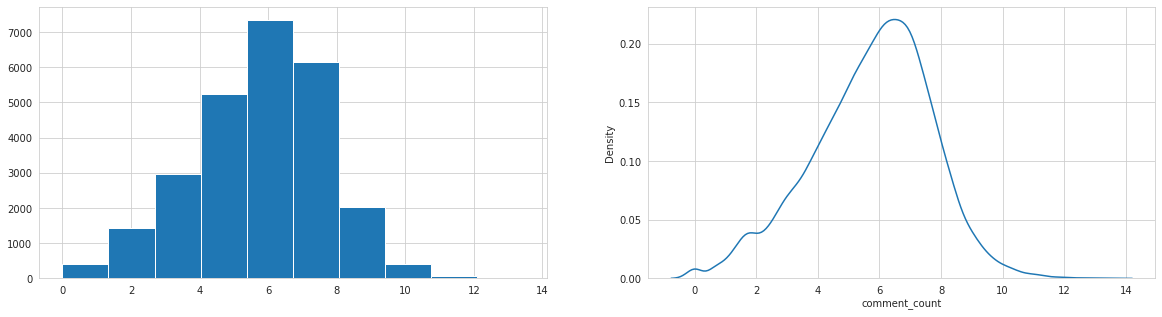



Analysing: likes


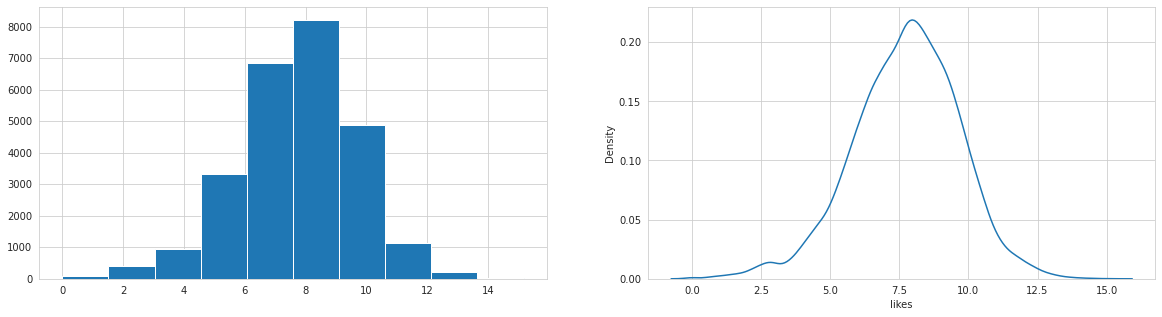

In [14]:
# plot histogram and a kernel density plot of data wrt target variable (term deposit subscribed)
for col in num_cols+[TARGET_COL]:
  print(f'Analysing: {col}')
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
  np.log1p(train[col]).hist(ax=ax1)
  sns.kdeplot(np.log1p(train[col]), ax=ax2)
  plt.show();
  print('\n')

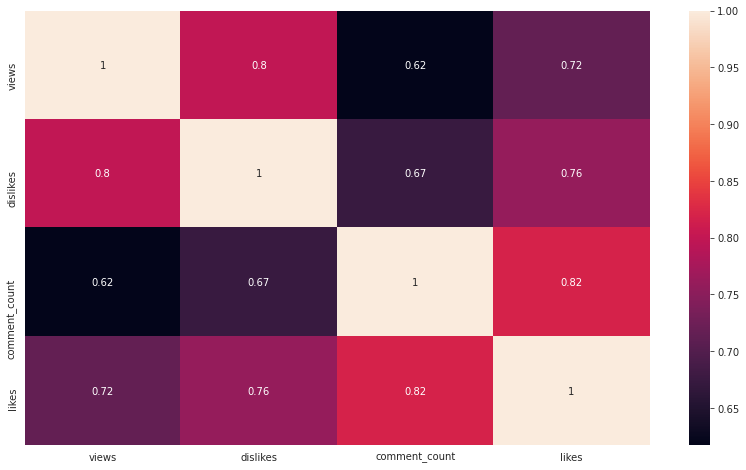

In [15]:
# plot correlation heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(np.log1p(train[num_cols+[TARGET_COL]]).corr(), annot=True);

CPU times: user 4.39 s, sys: 108 ms, total: 4.49 s
Wall time: 4.42 s


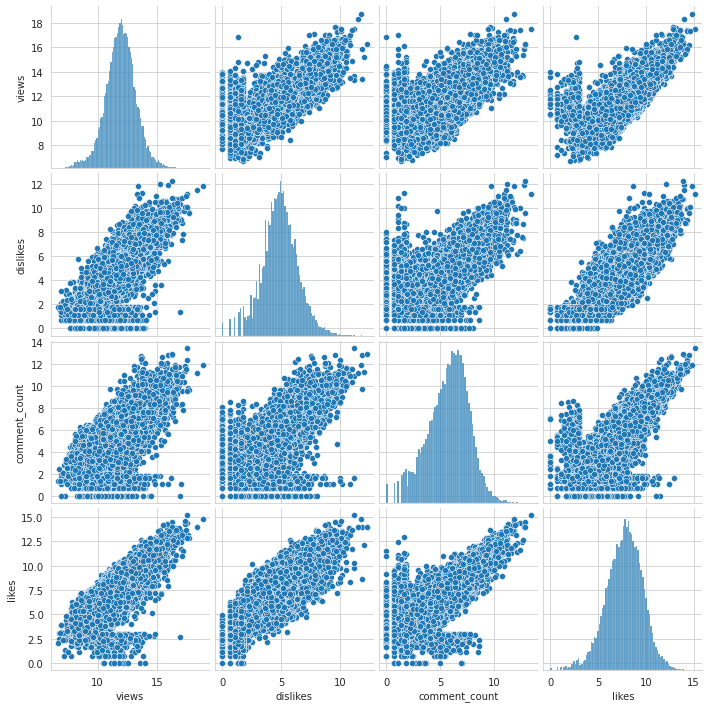

In [16]:
%%time
# pairplots => these always take long to render
sns.pairplot(np.log1p(train[num_cols+[TARGET_COL]]));

#### Observations
All numerical columns are log-normal, views and dislikes highly correlated. Target likes are highly correlated with all numerical independent variables. 
We could probably have a decent prediction just using these columns (hence dropping the text columns shouldn't make a massive difference for now).

## Baseline Model
Alright, after basic EDA of all variables, it's time to introduce the basic Catboost model with no tuning as a baseline.

In [17]:
# data preparation
y = train[TARGET_COL].values
X = train.drop([TARGET_COL, ID_COL, 'title', 'tags', 'description'], axis=1)
X.head()

,channel_title,category_id,publish_date,views,dislikes,comment_count,country_code
0,HUM TV,24.0,2017-12-12,351430.0,298.0,900.0,CA
1,ABS-CBN Entertainment,24.0,2018-03-08,461508.0,74.0,314.0,CA
2,SANDALWOOD REVIEWS,24.0,2018-03-26,40205.0,150.0,100.0,IN
3,doddleoddle,10.0,2018-02-21,509726.0,847.0,4536.0,GB
4,Dude Seriously,23.0,2018-05-10,74311.0,69.0,161.0,IN


In [18]:
# categorical features declaration
cat_features = cat_cols + ['publish_date', 'channel_title']
cat_features

['category_id', 'country_code', 'publish_date', 'channel_title']

In [19]:
# fillnas and convert to right data types
print(X[cat_features].info())

X_filled = X.copy()
X_filled["category_id"] = X["category_id"].astype(np.int16)

X_filled[cat_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26061 entries, 0 to 26060
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   category_id    26061 non-null  float64
 1   country_code   26061 non-null  object 
 2   publish_date   26061 non-null  object 
 3   channel_title  26061 non-null  object 
dtypes: float64(1), object(3)
memory usage: 814.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26061 entries, 0 to 26060
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   category_id    26061 non-null  int16 
 1   country_code   26061 non-null  object
 2   publish_date   26061 non-null  object
 3   channel_title  26061 non-null  object
dtypes: int16(1), object(3)
memory usage: 661.8+ KB


In [20]:
# import train test split, then split the data into train and test set
# cross validation is not included in the baseline => model could overfit
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X_filled, y, train_size=0.8, random_state=SEED, shuffle=True)

In [21]:
model = CatBoostRegressor(
    loss_function='Tweedie:variance_power=1.9',
      # Tweedie loss has worked wonders in previous kaggle comps modelling strange, 
      # Poisson-like distributions, it turns out to work well here as well
      # more details here: https://stats.stackexchange.com/questions/492726/what-is-use-of-tweedie-or-poisson-loss-objective-function-in-xgboost-and-deep-le
    random_seed=SEED,    # set seed for reproducibility
    eval_metric='MSLE',  # set the same metric as in the competition
#     task_type='GPU'    # GPU does not work for Tweedie loss :/
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    use_best_model=True,
    eval_set=(X_validation, y_validation),
    verbose=50
)
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

0:	learn: 63.0488718	test: 63.3900575	best: 63.3900575 (0)	total: 83ms	remaining: 1m 22s
50:	learn: 49.1816641	test: 49.4679398	best: 49.4679398 (50)	total: 1.69s	remaining: 31.5s
100:	learn: 42.9424624	test: 43.2011343	best: 43.2011343 (100)	total: 3.25s	remaining: 28.9s
150:	learn: 39.0388839	test: 39.2794343	best: 39.2794343 (150)	total: 4.86s	remaining: 27.3s
200:	learn: 36.3599589	test: 36.5879924	best: 36.5879924 (200)	total: 6.44s	remaining: 25.6s
250:	learn: 34.6895950	test: 34.9118270	best: 34.9118270 (250)	total: 7.96s	remaining: 23.7s
300:	learn: 34.0791345	test: 34.3005940	best: 34.3005940 (300)	total: 9.59s	remaining: 22.3s
350:	learn: 33.9920518	test: 34.2193143	best: 34.2193143 (350)	total: 11.2s	remaining: 20.7s
400:	learn: 33.9895898	test: 34.2170543	best: 34.2010313 (380)	total: 12.8s	remaining: 19.2s
450:	learn: 33.9986020	test: 34.2287529	best: 34.2010313 (380)	total: 14.3s	remaining: 17.4s
500:	learn: 34.0068053	test: 34.2343207	best: 34.2010313 (380)	total: 15.8s	

In [22]:
print('Tree count: ' + str(model.tree_count_))

Tree count: 381


In [23]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,comment_count,60.776699
1,views,20.077523
2,dislikes,12.546723
3,category_id,5.634881
4,country_code,0.964174
5,channel_title,0.000000
6,publish_date,0.000000


In [24]:
X_test = test.drop([ID_COL, 'title', 'tags', 'description'], axis=1)
X_test.head()

,channel_title,category_id,publish_date,views,dislikes,comment_count,country_code
0,CHIRRAVURI FOUNDATION,22.0,2018-01-17,80793.0,54.0,79.0,IN
1,VIRAL IN INDIA,22.0,2017-11-18,150317.0,230.0,311.0,IN
2,Saskatchewan Roughriders,17.0,2017-12-01,6558.0,10.0,7.0,CA
3,Matthias Wandel,26.0,2018-02-06,89664.0,145.0,324.0,US
4,AVA Creative thoughts,22.0,2018-02-06,53526.0,357.0,153.0,IN


In [25]:
# fillnas and convert to right data types TEST
print(X_test[cat_features].info())

X_test_filled = X_test.copy()
X_test_filled["category_id"] = X_test["category_id"].astype(np.int16)

X_test_filled[cat_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11170 entries, 0 to 11169
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   category_id    11170 non-null  float64
 1   country_code   11170 non-null  object 
 2   publish_date   11170 non-null  object 
 3   channel_title  11170 non-null  object 
dtypes: float64(1), object(3)
memory usage: 349.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11170 entries, 0 to 11169
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   category_id    11170 non-null  int16 
 1   country_code   11170 non-null  object
 2   publish_date   11170 non-null  object
 3   channel_title  11170 non-null  object
dtypes: int16(1), object(3)
memory usage: 283.7+ KB


In [26]:
contest_predictions = model.predict(X_test_filled)
print('Predictions:')
print(contest_predictions)

Predictions:
[  792.32025174  2267.42416482   313.2757626  ...  5558.09271849
 11900.57430592  4262.99567486]


In [27]:
ss[TARGET_COL] = contest_predictions.round(0).astype(np.int16)
ss.head()

,video_id,likes
0,87185,792
1,9431,2267
2,40599,313
3,494,2833
4,73942,1074


In [28]:
ss.to_csv("catboost_baseline.csv", index = False)

In [29]:
# and we're done!
'Done!'

'Done!'